In [1]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns                                   # For pretty plot
from datetime import datetime, timedelta

import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 50     

## Load ELL data

In [60]:
power = pd.read_csv('ELL data/power.csv', sep=';', parse_dates=['time'])
irrad = pd.read_csv('ELL data/irradiance.csv', sep=';', parse_dates=['time'])
tempWind = pickle.load(open("ELL data/ELL_temp_wind_df.p","rb"))

In [61]:
power.head()

,time,power
0,2016-01-01 01:00:00,null
1,2016-01-01 01:01:00,null
2,2016-01-01 01:02:00,null
3,2016-01-01 01:03:00,null
4,2016-01-01 01:04:00,null


In [62]:
irrad.head()

,time,irradiance
0,2016-01-01 01:00:00,null
1,2016-01-01 01:01:00,null
2,2016-01-01 01:02:00,null
3,2016-01-01 01:03:00,null
4,2016-01-01 01:04:00,null


In [63]:
tempWind = tempWind.reset_index()
tempWind.head()

,index,Temp,Wind
0,2016-01-01 01:00:00,7.30,0.0
1,2016-01-01 01:01:00,7.32,0.0
2,2016-01-01 01:02:00,7.34,0.0
3,2016-01-01 01:03:00,7.36,0.0
4,2016-01-01 01:04:00,7.38,0.0


## Null values handling

In [64]:
whereis_null_power = power.copy()
whereis_null_power.loc[whereis_null_power.power != 'null', 'power'] = 0
whereis_null_power.loc[whereis_null_power.power == 'null', 'power'] = 1

In [65]:
whereis_null_power.head()

,time,power
0,2016-01-01 01:00:00,1
1,2016-01-01 01:01:00,1
2,2016-01-01 01:02:00,1
3,2016-01-01 01:03:00,1
4,2016-01-01 01:04:00,1


Plot 1 where power is null, 0 otherwise.

In [66]:
# x = np.array(range(whereis_null_power.shape[0]))
# y = whereis_null_power.power
# str_xticks = whereis_null_power.time
# plt.xticks(x, str_xticks)
# plt.bar(x, y)
# plt.show()

In [67]:
whereis_null_power['power'].value_counts()

0    261641
1     13159
Name: power, dtype: int64

Replace null values with zeros.

In [68]:
power.replace(to_replace='null', value=0, inplace=True)
irrad.replace(to_replace='null', value=0, inplace=True)

**TODO:** Are we sure we wanna set null values to 0s? This might affect our learning function. Why don't we just drop these rows.

## Add timestamp to each measurement

Convert measurement from string to float.

In [69]:
power['power'] = power['power'].astype(float)
irrad['irradiance'] = irrad['irradiance'].astype(float)

In [70]:
power.head()

,time,power
0,2016-01-01 01:00:00,0.0
1,2016-01-01 01:01:00,0.0
2,2016-01-01 01:02:00,0.0
3,2016-01-01 01:03:00,0.0
4,2016-01-01 01:04:00,0.0


Add timestamp to each measurement as difference in seconds from the first measurement.
**TODO:** correct me if I'm wrong

In [71]:
def get_timestamp_from_time(measurement_datetime, reference_datetime=datetime(2016, 1, 1, 1, 0, 0)):
    """
    Retrieve the difference in time between measurement_time and reference_time.
    :param measurement_datetime: pandas.tslib.Timestamp value of a measurement
    :param reference_datetime: reference datetime value (Default: 01/01/2016 1:00am)
    :return: difference in seconds between measurement_datetime and reference_datetime
    """
    
    return (measurement_datetime - reference_datetime) // timedelta(seconds=1)

In [72]:
# old
# seconds = power['time'].apply(lambda x: (datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ")  - datetime(2016, 1, 1, 1, 0, 0))  //timedelta(seconds=1))

In [73]:
seconds = power['time'].apply(get_timestamp_from_time)

In [74]:
power['timestamp'] = seconds
irrad['timestamp'] = seconds
tempWind['timestamp'] = seconds

In [75]:
power.head()

,time,power,timestamp
0,2016-01-01 01:00:00,0.0,0
1,2016-01-01 01:01:00,0.0,60
2,2016-01-01 01:02:00,0.0,120
3,2016-01-01 01:03:00,0.0,180
4,2016-01-01 01:04:00,0.0,240


In [76]:
tempWind.head()

,index,Temp,Wind,timestamp
0,2016-01-01 01:00:00,7.30,0.0,0
1,2016-01-01 01:01:00,7.32,0.0,60
2,2016-01-01 01:02:00,7.34,0.0,120
3,2016-01-01 01:03:00,7.36,0.0,180
4,2016-01-01 01:04:00,7.38,0.0,240


## Number of panels doubled on May 24, 2016

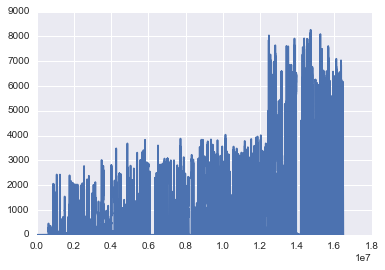

In [77]:
plt.plot(power['timestamp'], power['power'])

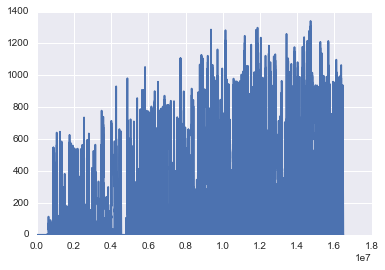

In [78]:
plt.plot(irrad['timestamp'], irrad['irradiance'])

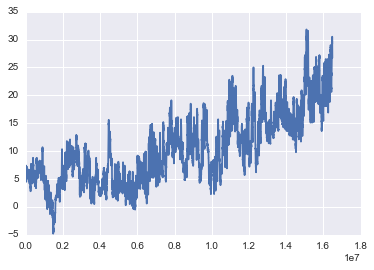

In [79]:
plt.plot(tempWind['timestamp'], tempWind['Temp'])

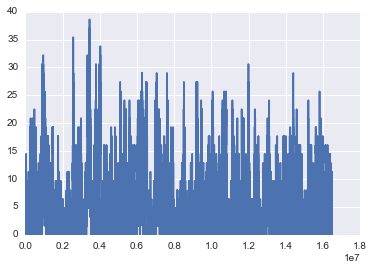

In [80]:
plt.plot(tempWind['timestamp'], tempWind['Wind'])

**TODO:** Please, write some comments :P <br>
It took me a while before I remembered that this was the date the #panels doubled... ^^"

In [81]:
new_panels_date = datetime(2016,5,24,7,31,0)

In [82]:
ts_double_panels = get_timestamp_from_time(new_panels_date)

In [83]:
indx = power[power.timestamp >= ts_double_panels].index

Divide the power by 2 to take into account the doubled number of panels.

In [84]:
y = power.loc[power.timestamp >= ts_double_panels]['power'] / 2
y.head()

207751    0.0
207752    0.0
207753    0.0
207754    0.0
207755    0.0
Name: power, dtype: float64

In [85]:
power.ix[power.timestamp >= ts_double_panels, 'power'] = y

In [86]:
power.loc[indx].tail()

,time,power,timestamp
274795,2016-07-09 20:55:00,0.005,16487700
274796,2016-07-09 20:56:00,0.005,16487760
274797,2016-07-09 20:57:00,0.005,16487820
274798,2016-07-09 20:58:00,0.005,16487880
274799,2016-07-09 20:59:00,0.005,16487940


Irradiance is measured in $W/m^2$ and thus we do not need to modify our data.

## Plot

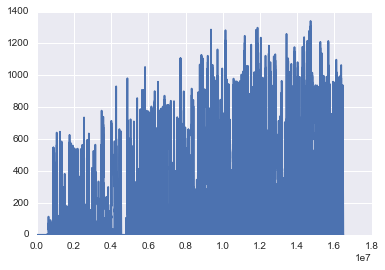

In [87]:
plt.plot(power['timestamp'], irrad['irradiance'])

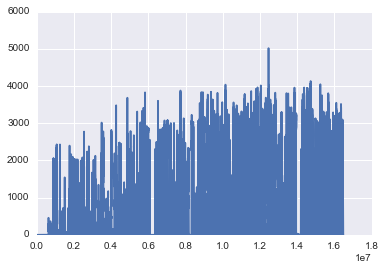

In [88]:
plt.plot(power['timestamp'], power['power'])

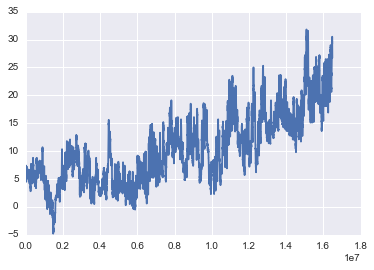

In [90]:
plt.plot(tempWind['timestamp'], tempWind['Temp'])

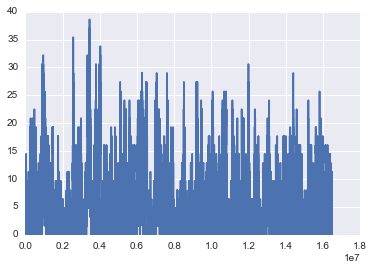

In [89]:
plt.plot(tempWind['timestamp'], tempWind['Wind'])

## Predict future values

Similar project:
http://cs229.stanford.edu/proj2014/Mayukh%20Samanta,Bharath%20Srikanth,Jayesh%20Yerrapragada,Short%20Term%20Power%20Forecasting%20Of%20Solar%20PV%20Systems%20Using%20Machine%20Learning%20Techniques.pdf

In [91]:
from sklearn import linear_model
# from sklearn.model_selection import cross_val_predict

In [92]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict

/Users/mohiuddi/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [102]:
features_df = pd.concat([Gmi, tempWind],axis = 1)
features_df = features_df.drop(['index', 'timestamp'], axis=1)
features_df.head()

,irradiance,Temp,Wind
0,0.0,7.30,0.0
1,0.0,7.32,0.0
2,0.0,7.34,0.0
3,0.0,7.36,0.0
4,0.0,7.38,0.0


In [103]:
Pdc = power['power']
X = features_df.values

In [105]:
lin_reg = linear_model.LinearRegression()

In [106]:
scores = cross_val_score(lin_reg, X, Pdc, cv=10, n_jobs=-1)

In [107]:
print(scores.mean())

0.888351922787


In [109]:
lin_reg.fit(X, Pdc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [111]:
lin_reg.predict((0,0,0))

/Users/mohiuddi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 29.17993055])

In [122]:
lin_reg.predict([0,-1,0])

/Users/mohiuddi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 30.40713669])

In [119]:
lin_reg.predict([1000, 0, 0])

/Users/mohiuddi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 3396.92089405])

In [123]:
predicted = cross_val_predict(lin_reg, X, Pdc, cv=10, n_jobs=-1)

## Removing null values instead of setting them to 0

In [125]:
power2 = pd.read_csv('ELL data/power.csv', sep=';', parse_dates=['time'])
irrad2 = pd.read_csv('ELL data/irradiance.csv', sep=';', parse_dates=['time'])

In [126]:
power2 = power2[power2.power != 'null']
irrad2 = irrad2[irrad2.irradiance != 'null']

In [127]:
power2['power'] = power2['power'].astype(float)
irrad2['irradiance'] = irrad2['irradiance'].astype(float)

In [128]:
seconds = power2['time'].apply(get_timestamp_from_time)

In [129]:
power2['timestamp'] = seconds
irrad2['timestamp'] = seconds

In [11]:
power2.head()

,time,power,timestamp
9519,2016-01-07 15:39:00,0.02,571140
9520,2016-01-07 15:40:00,0.02,571200
9521,2016-01-07 15:41:00,0.02,571260
9522,2016-01-07 15:42:00,0.02,571320
9523,2016-01-07 15:43:00,0.02,571380


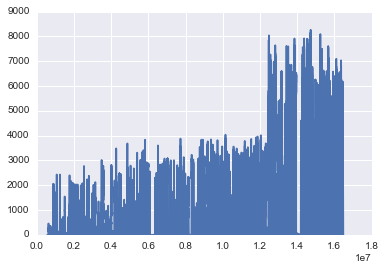

In [12]:
plt.plot(power2['timestamp'], power2['power'])

In [13]:
new_panels_date = datetime(2016,5,24,7,31,0)

In [14]:
ts_double_panels = get_timestamp_from_time(new_panels_date)

In [15]:
indx2 = power2[power2.timestamp >= ts_double_panels].index

Divide the power by 2 to take into account the doubled number of panels.

In [16]:
y2 = power2.loc[power2.timestamp >= ts_double_panels]['power'] / 2
y2.head()

207798    2504.385625
207799    2704.956167
207800    2720.176167
207801    2751.893000
207802    2767.678000
Name: power, dtype: float64

In [17]:
power2.ix[power2.timestamp >= ts_double_panels, 'power'] = y2

In [19]:
power2.loc[indx2].tail()

,time,power,timestamp
274795,2016-07-09 20:55:00,0.005,16487700
274796,2016-07-09 20:56:00,0.005,16487760
274797,2016-07-09 20:57:00,0.005,16487820
274798,2016-07-09 20:58:00,0.005,16487880
274799,2016-07-09 20:59:00,0.005,16487940


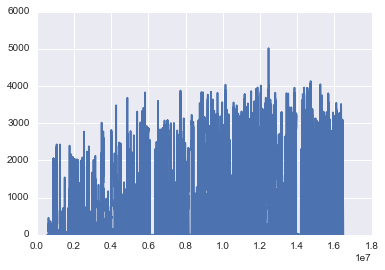

In [20]:
plt.plot(power2.timestamp, power2.power)

In [133]:
Pdc2 = power2['power']
Gmi2 = irrad2['irradiance']

In [138]:
features2_df = pd.concat([Gmi2, tempWind],axis = 1, join='inner')
features2_df = features2_df.drop(['index', 'timestamp'], axis=1)
features2_df.head()

,irradiance,Temp,Wind
9519,5.380000,5.78,1.92
9520,5.558833,5.80,1.60
9521,5.683167,5.84,1.60
9522,5.636500,5.88,1.60
9523,5.444833,5.92,1.60


In [147]:
X2 = features2_df.values

In [148]:
from sklearn import linear_model
# from sklearn.model_selection import cross_val_predict

In [149]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict

In [150]:
lin_reg2 = linear_model.LinearRegression()

In [151]:
scores2 = cross_val_score(lin_reg2, X2, Pdc2, cv=10, n_jobs=-1)

In [152]:
print(scores2.mean())

0.718673358345


Dropping null values has decreased the score

In [153]:
lin_reg2.fit(X2, Pdc2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [154]:
lin_reg2.predict((0,0,0))

/Users/mohiuddi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([-257.3418355])

In [155]:
lin_reg2.predict((1,0,0))

/Users/mohiuddi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([-252.68133681])

Predicting negative values. This is not good!

In [157]:
lin_reg2.predict((1000, 10, 2))

/Users/mohiuddi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 4664.20199746])

In [158]:
predicted2 = cross_val_predict(lin_reg2, X, Pdc2, cv=10, n_jobs=-1)

## Other regression models

In [159]:
from sklearn.svm import SVR

In [68]:
# svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
# svr_lin = SVR(kernel='linear', C=1e3)
# svr_poly2 = SVR(kernel='poly', C=1e3, degree=2)

In [69]:
# scores_rbf = cross_val_score(svr_rbf, Gmi2.reshape(-1,1), Pdc2, cv=10, n_jobs=-1)
# scores_rbf.mean()

In [70]:
# scores_lin = cross_val_score(svr_lin, Gmi2.reshape(-1,1), Pdc2, cv=10, n_jobs=-1)
# scores_lin.mean()

In [71]:
# scores_poly2 = cross_val_score(svr_poly2, Gmi2.reshape(-1,1), Pdc2, cv=10, n_jobs=-1)
# scores_poly2.mean()

Too slow...

### Polynomial interpolation

In [160]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [161]:
colors = ['red', 'yellowgreen', 'gold']

ValueError: x and y must be the same size

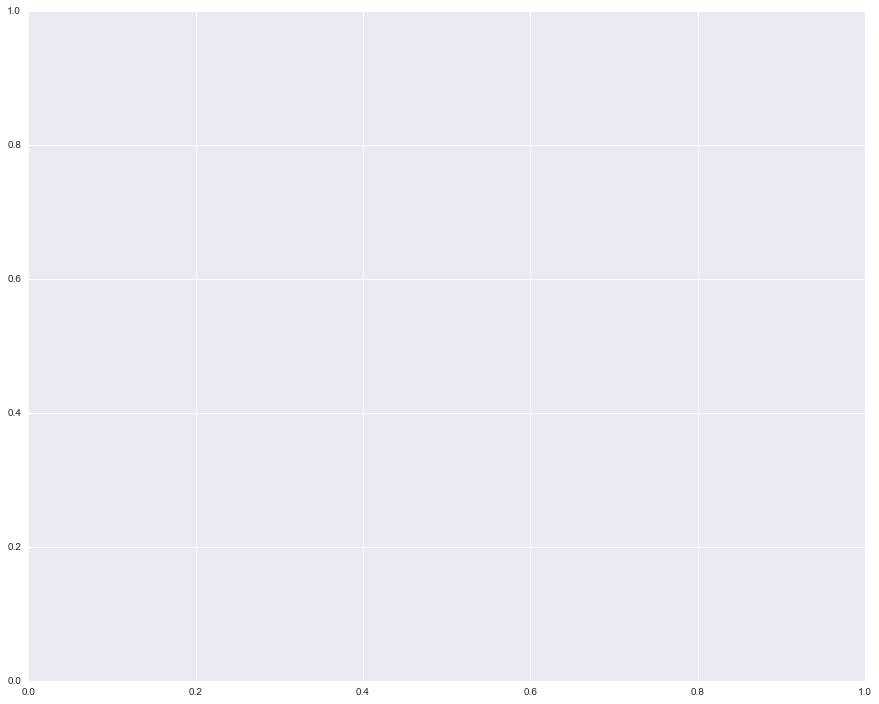

In [162]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(X2, Pdc2, color='cornflowerblue', label="ground truth")
for count, degree in enumerate([3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X2.reshape(-1,1), Pdc2)
    y_plot = model.predict(X2)
    plt.plot(Gmi2, y_plot, color=colors[count], label="degree %d" % degree)


In [163]:
model = make_pipeline(PolynomialFeatures(2), Ridge())

In [164]:
scores_poly2 = cross_val_score(model, X2, Pdc2, cv=10, n_jobs=-1)
scores_poly2.mean()

0.83023499743878271

In [165]:
model = make_pipeline(PolynomialFeatures(3), Ridge())

In [166]:
scores_poly3 = cross_val_score(model, X2, Pdc2, cv=10, n_jobs=-1)
scores_poly3.mean()

0.81018566289875671

In [167]:
for degree in range(1,11):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    print(degree, '\t', cross_val_score(model, Gmi2.reshape(-1,1), Pdc2, cv=10, n_jobs=-1).mean())

1 	 0.719259476612
2 	 0.732146692443
3 	 0.730444148236
4 	 0.729109962771
5 	 0.728779062462
6 	 0.727962437489
7 	 0.727003530405
8 	 0.72690316141
9 	 0.725592573429
10 	 0.724938042959


PolynomialFeatures gives columns: $[1, x^1, x^2, ..., x^{degree}]$ for each column x of passed matrix X

**TODO:** combine these columns (given by fit_transform(Gmi\_)) to create new columns of their products

Degree 2 gives the best accuracy: we use this model.

In [169]:
model = make_pipeline(PolynomialFeatures(2), Ridge())
model.fit(X2, Pdc2)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [44]:
import pickle

In [170]:
pickle.dump(model, open('model_with_temp_wind.p', 'wb'))